In [201]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from scipy.stats import percentileofscore
from pathlib import Path
from time import sleep

### Data Storytelling
 - **Dataset**
   - nfl draft
 - **Audience**
   - semi-technical, briefing for analysts discussing draft trends over history. do past results provide as reasonable expectations as individual player projections?
 - **Exploration**
   - initial looks
   - focus on QB position, others may be harder to corral and compare
     - popular position for top picks this year
   - what metrics can measure performance?
     - AV, AV/G
     - passing yds, games playhed, years starter?
  - **Narrative**
    - defined performance as a roughly modified AV/G. career performance metric divided by games played
    - considered various "tiers" of QBs defined by metric percentile
    - determined performance history at various pick ranges
      - calculated "bust percentage", number of picks with performance below threshold
      - will then use to craft a "safety" assessment of assured performance at top picks, and a "gamble" assessment of possible gems at late picks

#### Dataset Collection
 - HTML tables from `pro-football-reference.com/`
 - minimal cleaning

In [3]:
class DraftTable:
    def __init__(self, year):
        self.year = year
        self.table = None
    
    def data_import(self):
        URL = f"https://www.pro-football-reference.com/years/{self.year}/draft.htm"
        data = pd.read_html(URL)[0]
        
        # clean column names, drop extras
        rename = []
        for c_name in data.columns:
            if c_name[0].startswith('Unnamed:'):
                rename.append(c_name[1])
            else:
                rename.append(f"{c_name[0]}_{c_name[1]}")
        data.columns = rename
        data.rename(columns={'St':'Yrs_Starter', 'Solo':'Tackles_Solo', 'College/Univ':'Uni'}, inplace=True)
        data.drop(data.columns[-1], inplace=True, axis=1)
        data.fillna(0, inplace=True)
        data = data[data.Pos!='Pos']
        data.loc[:,'draft_year'] = self.year
        self.table = data
        
    def save(self, folder):
        if type(self.table) == type(None):
            return
        p = Path(folder, f'draft_{self.year}.csv')
        self.table.to_csv(p)
    
    def dtypes_opt(self):
        if type(self.table) == type(None):
            return
        # ignore warning for this
        pd.options.mode.chained_assignment = None
        
        # object --> string
        str_cols = ['Tm','Player','Pos','Uni']
        self.table[str_cols] = self.table[str_cols].astype('string')
        # sack --> float
        self.table['Sk'] = self.table['Sk'].astype(float)
        # rest --> int
        int_cols = self.table.columns[~self.table.columns.isin(str_cols + ['Sk'])]
        self.table[int_cols] = self.table[int_cols].astype(int)

        # restore warning
        pd.options.mode.chained_assignment = 'warn'

In [6]:
df = pd.DataFrame()

for year in range(1990,2024):
    t = DraftTable(year)
    t.data_import()
    df = pd.concat([df, t.table])
    # t.save(Path('draft_tables'))
    sleep(1)
    print(year, 'completed')
    
df.reset_index(drop=True,inplace=True)
df.head()

1990 completed
1991 completed
1992 completed
1993 completed
1994 completed
1995 completed
1996 completed
1997 completed
1998 completed
1999 completed
2000 completed
2001 completed
2002 completed
2003 completed
2004 completed
2005 completed
2006 completed
2007 completed
2008 completed
2009 completed
2010 completed
2011 completed
2012 completed
2013 completed
2014 completed
2015 completed
2016 completed
2017 completed
2018 completed
2019 completed
2020 completed
2021 completed
2022 completed
2023 completed


,Rnd,Pick,Tm,Player,Pos,Age,To,Misc_AP1,Misc_PB,Yrs_Starter,...,Rushing_Yds,Rushing_TD,Receiving_Rec,Receiving_Yds,Receiving_TD,Int,Sk,Uni,draft_year,Tackles_Solo
0,1,1,IND,Jeff George,QB,22,2001,0,0,9,...,307,2,0,0,0,0,0,Illinois,1990,NaN
1,1,2,NYJ,Blair Thomas,RB,22,1995,0,0,3,...,2236,7,71,513,2,0,0,Penn St.,1990,NaN
2,1,3,SEA,Cortez Kennedy HOF,DT,22,2000,3,8,9,...,0,0,0,0,0,3,58.0,Miami (FL),1990,NaN
3,1,4,TAM,Keith McCants,DE,22,1995,0,0,2,...,0,0,0,0,0,1,13.5,Alabama,1990,NaN
4,1,5,SDG,Junior Seau HOF,LB,21,2009,6,12,16,...,0,0,2,8,0,18,56.5,USC,1990,NaN


In [10]:
# ignore warning for this
pd.options.mode.chained_assignment = None
df.drop(columns='Tackles_Solo', inplace=True)

# object --> string
str_cols = ['Tm','Player','Pos','Uni']
df[str_cols] = df[str_cols].astype('string')
# sack --> float
df['Sk'] = df['Sk'].astype(float)
# rest --> int
int_cols = df.columns[~df.columns.isin(str_cols + ['Sk'])]
df[int_cols] = df[int_cols].astype(int)

# restore warning
pd.options.mode.chained_assignment = 'warn'

In [41]:
pd.options.mode.chained_assignment = None
df.drop(columns = ['Receiving_Rec', 'Receiving_Yds', 'Receiving_TD', 'Sk', 'Int', 'Approx Val_DrAV',], inplace=True)
df.rename(columns = {'Misc_AP1':'AP1', 'Misc_PB':'PB', 'Approx Val_wAV':'wAV',
                     }, inplace=True)
pass_rename = {col:col.replace('Passing_','') for col in df.columns[df.columns.str.startswith('Passing')]}
df.rename(columns = pass_rename, inplace=True)
pd.options.mode.chained_assignment = 'warn'

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8814 entries, 0 to 8813
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rnd          8814 non-null   int64 
 1   Pick         8814 non-null   int64 
 2   Tm           8814 non-null   object
 3   Player       8814 non-null   object
 4   Pos          8814 non-null   object
 5   Age          8814 non-null   int64 
 6   To           8814 non-null   int64 
 7   AP1          8814 non-null   int64 
 8   PB           8814 non-null   int64 
 9   Yrs_Starter  8814 non-null   int64 
 10  wAV          8814 non-null   int64 
 11  G            8814 non-null   int64 
 12  Cmp          8814 non-null   int64 
 13  Att          8814 non-null   int64 
 14  Yds          8814 non-null   int64 
 15  TD           8814 non-null   int64 
 16  Int          8814 non-null   int64 
 17  Rushing_Att  8814 non-null   int64 
 18  Rushing_Yds  8814 non-null   int64 
 19  Rushing_TD   8814 non-null   int

In [43]:
df.to_csv(Path('nfl_draft_table.csv'))

#### Exploration
 - 8814 draft picks from 1990-2023
 - 418 quarterbacks

In [231]:
df = pd.read_csv(Path('nfl_draft_table.csv'), index_col=0)

In [37]:
df.shape[0], df[df.Pos == 'QB'].shape[0]

(8814, 418)

In [232]:
df = df[df.Pos == 'QB']

In [45]:
df.sample(3).T

,8558,1001,614
Rnd,1,1,11
Pick,4,1,284
Tm,IND,NWE,DEN
Player,Anthony Richardson,Drew Bledsoe,Shawn Moore
Pos,QB,QB,QB
Age,21,21,23
To,2023,2006,1992
AP1,0,0,0
PB,0,4,0
Yrs_Starter,0,12,0


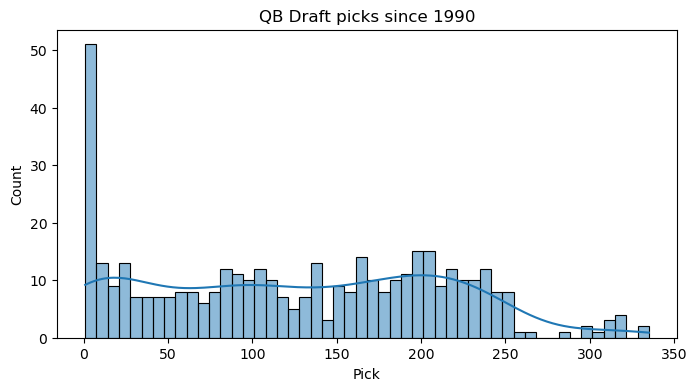

In [52]:
plt.figure(figsize=(8,4))
sns.histplot(df.Pick, kde=True, bins=50)
plt.title("QB Draft picks since 1990")
plt.show()

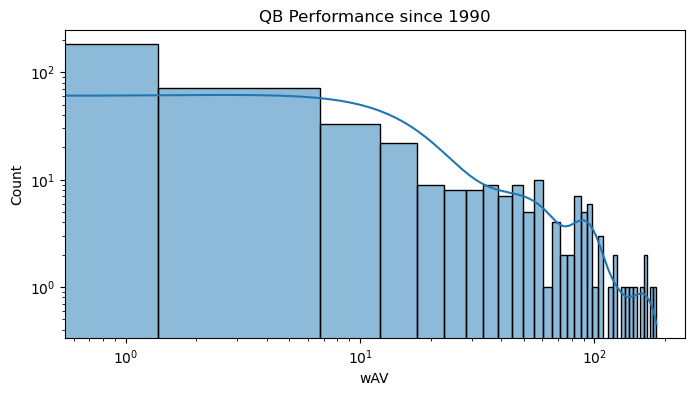

In [233]:
plt.figure(figsize=(8,4))
sns.histplot(df.wAV, kde=True)
plt.title("QB Performance since 1990")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [71]:
df.G.describe()

count    418.000000
mean      38.574163
std       56.956296
min        0.000000
25%        1.000000
50%       14.500000
75%       53.750000
max      335.000000
Name: G, dtype: float64

<Axes: xlabel='G'>

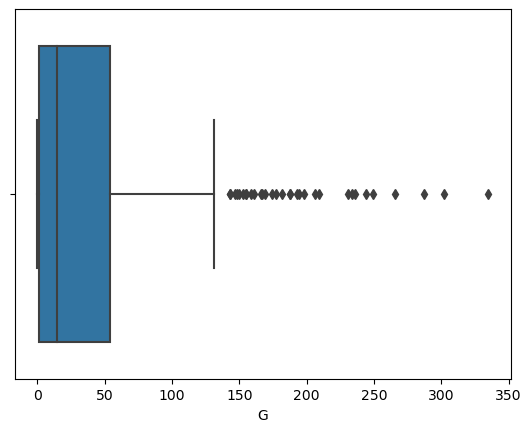

In [70]:
sns.boxplot(x=df.G)

**Performance Tiers** | *defined by modified `wAV` percentile*

 - wAV measures overall career and will not allow for recent players, normalize wAV by games played `G`
 - raw normalization favors QBs who start strong, as they have not yet had to maintain consistent high performance
   - ex: Mahomes vs Stroud/Purdy
 - added modification factors: `wAV**X` and `G+1+Y`. earlier draft years are likely overvalued now

In [247]:
df = pd.read_csv(Path('nfl_draft_table.csv'), index_col=0)
df = df[df.Pos == 'QB']

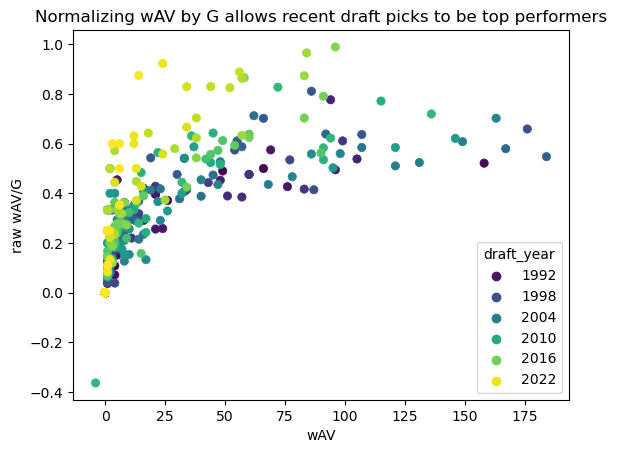

In [248]:
sns.scatterplot(df, y=df.wAV/(df.G+1), x='wAV', hue='draft_year', edgecolor='face', palette='viridis')
plt.ylabel('raw wAV/G')
plt.title('Normalizing wAV by G allows recent draft picks to be top performers')
plt.show()

In [249]:
df['wAV'] = df.wAV**(1.5)/(df.G+2)
print('dropping', df[df.wAV.isna()].Player)
df.drop(index=df[df.wAV.isna()].index, inplace=True)

dropping 5928    Ryan Lindley
Name: Player, dtype: object


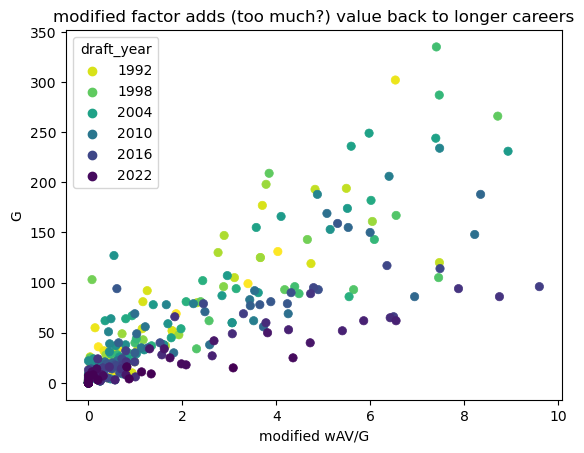

In [254]:
sns.scatterplot(df, x='wAV', y='G', hue='draft_year', edgecolor='face', palette='viridis_r')
plt.xlabel('modified wAV/G')
plt.title('modified factor adds (too much?) value back to longer careers')
plt.show()


*determine percentile cutoffs*

In [167]:
cutoffs = np.percentile(df.wAV, [90, 95, 98, 99])

In [168]:
cutoffs

array([4.7586289 , 6.36327651, 7.47353367, 8.32732655])

*sanity check, scrollable for notebook views. commenting out for online viewing*

In [255]:
# df[['wAV','Pick','Player','Yrs_Starter','draft_year']].sort_values('wAV', ascending=False).head(50)

**Tier I, 99th percentile**

In [256]:
df[df.wAV>= cutoffs[-1]]

,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,Yrs_Starter,...,Cmp,Att,Yds,TD,Int,Rushing_Att,Rushing_Yds,Rushing_TD,Uni,draft_year
2190,1,1,IND,Peyton Manning HOF,QB,22,2015,7,14,17,...,6125,9380,71940,539,251,431,667,18,Tennessee,1998
3985,1,24,GNB,Aaron Rodgers,QB,21,2023,4,10,14,...,5001,7661,59055,475,105,719,3466,35,California,2005
5818,3,75,SEA,Russell Wilson,QB,23,2023,0,9,11,...,3668,5665,43653,334,106,981,5307,29,Wisconsin,2012
7025,1,10,KAN,Patrick Mahomes,QB,21,2023,2,6,5,...,2386,3590,28424,219,63,374,1936,12,Texas Tech,2017
7300,1,32,BAL,Lamar Jackson,QB,21,2023,2,3,4,...,1362,2112,15887,125,45,875,5258,29,Louisville,2018


**Tier II, 98th percentile**

In [257]:
df[df.wAV.between(cutoffs[-2],cutoffs[-1])]

,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,Yrs_Starter,...,Cmp,Att,Yds,TD,Int,Rushing_Att,Rushing_Yds,Rushing_TD,Uni,draft_year
4729,1,3,ATL,Matt Ryan,QB,23,2022,1,4,15,...,5551,8464,62792,381,183,514,1539,13,Boston Col.,2008
5490,1,1,CAR,Cam Newton,QB,22,2021,1,3,9,...,2682,4474,32382,194,123,1118,5628,75,Auburn,2011
6897,4,135,DAL,Dak Prescott,QB,23,2023,0,4,6,...,2595,3873,29459,202,74,407,1884,28,Mississippi St.,2016
7275,1,7,BUF,Josh Allen,QB,22,2023,0,3,5,...,1989,3145,22703,167,78,657,3611,53,Wyoming,2018


**Tier III, 95th percentile**

In [258]:
df[df.wAV.between(cutoffs[-3],cutoffs[-2])]

,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,Yrs_Starter,...,Cmp,Att,Yds,TD,Int,Rushing_Att,Rushing_Yds,Rushing_TD,Uni,draft_year
363,2,33,ATL,Brett Favre HOF,QB,21,2010,3,11,19,...,6300,10169,71838,508,336,602,1844,14,Southern Miss,1991
1222,8,222,SDG,Trent Green,QB,23,2008,0,2,7,...,2266,3740,28475,162,114,243,914,6,Indiana,1993
2432,1,2,PHI,Donovan McNabb,QB,22,2011,0,6,11,...,3170,5374,37276,234,117,616,3459,29,Syracuse,1999
2441,1,11,MIN,Daunte Culpepper,QB,22,2009,0,3,5,...,2016,3199,24153,149,106,514,2652,34,Central Florida,1999
2882,6,199,NWE,Tom Brady,QB,23,2022,3,15,21,...,7753,12050,89214,649,212,693,1123,28,Michigan,2000
2969,2,32,SDG,Drew Brees,QB,22,2020,1,13,19,...,7142,10551,80358,571,243,498,752,25,Purdue,2001
3710,1,4,NYG,Philip Rivers,QB,22,2020,0,8,15,...,5277,8134,63440,421,209,383,601,3,North Carolina St.,2004
4979,1,1,DET,Matthew Stafford,QB,21,2023,0,2,13,...,4834,7649,56047,357,180,411,1315,15,Georgia,2009
5744,1,1,IND,Andrew Luck,QB,22,2018,0,4,5,...,2000,3290,23671,171,83,332,1590,14,Stanford,2012
7027,1,12,HOU,Deshaun Watson,QB,21,2023,0,3,3,...,1390,2089,16756,118,45,369,1994,19,Clemson,2017


**Tier IV, 90th percentile**

In [259]:
df[df.wAV.between(cutoffs[0],cutoffs[1])]

,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,Yrs_Starter,...,Cmp,Att,Yds,TD,Int,Rushing_Att,Rushing_Yds,Rushing_TD,Uni,draft_year
1001,1,1,NWE,Drew Bledsoe,QB,21,2006,0,4,12,...,3839,6717,44611,251,206,385,764,10,Washington St.,1993
1118,5,118,GNB,Mark Brunell,QB,22,2011,0,3,11,...,2761,4640,32072,184,108,513,2421,15,Washington,1993
1449,1,3,HOU,Steve McNair,QB,22,2007,0,3,10,...,2733,4544,31304,174,119,669,3590,37,Alcorn St.,1995
2561,4,131,GNB,Aaron Brooks,QB,23,2006,0,0,5,...,1673,2963,20261,123,92,362,1534,13,Virginia,1999
2938,1,1,ATL,Michael Vick,QB,21,2015,0,4,7,...,1807,3217,22464,133,88,873,6109,36,Virginia Tech,2001
3291,4,108,JAX,David Garrard,QB,24,2010,0,1,5,...,1406,2281,16003,89,54,380,1746,17,East Carolina,2002
3445,1,1,CIN,Carson Palmer,QB,23,2017,0,3,12,...,3941,6307,46247,294,187,301,474,8,USC,2003
3707,1,1,SDG,Eli Manning,QB,23,2019,0,4,14,...,4895,8119,57023,366,244,315,567,7,Mississippi,2004
3717,1,11,PIT,Ben Roethlisberger,QB,22,2021,0,6,17,...,5440,8443,64088,418,211,515,1373,20,Miami (OH),2004
3962,1,1,SFO,Alex Smith,QB,21,2020,0,3,14,...,3250,5193,35650,199,109,580,2604,15,Utah,2005


#### Build Narrative

In [260]:
cutoffs

array([4.7586289 , 6.36327651, 7.47353367, 8.32732655])

In [261]:
pick_tiers = [1,2,3,4,5,6,10,16,33,65,137, df.Pick.max()]

In [262]:
for i in range(len(pick_tiers)-1):
    pmin = pick_tiers[i]
    pmax = pick_tiers[i+1]
    sub = df[df.Pick.between(pmin,pmax, inclusive='left')]
    scores = percentileofscore(df.wAV,sub.wAV)
    best = sub[sub.wAV == sub.wAV.max()]
    if pmax == pmin+1:
        print(f'\twith pick {pmin}\t[{sub.shape[0]} QBs since 1990]')
    else:
        print(f'\tbetween picks {pmin} and {pmax}\n\t[{sub.shape[0]} QBs since 1990]')
    
    # Avg, Median performance
    print(f'{scores.mean():.1f} ± {scores.std():.2f}\tPerformance Percentile')
    print(f'{scores.min():.1f} to {scores.max():.1f}')
    # some kind of probability
    # busts (<90th percentile)
    print(f'{round(100*np.sum(scores<80)/sub.shape[0])}% busts \t<80th percentile')
    # best pick(s)
    print('\t\tbest pick')
    print(f'{best.Player.values[0]} {best.draft_year.values[0]} {best.Tm.values[0]}')
    print(f'{percentileofscore(df.wAV, best.wAV)[0]:.1f}th percentile')
    print()

	with pick 1	[21 QBs since 1990]
88.3 ± 10.90	Performance Percentile
54.0 to 99.3
14% busts 	<80th percentile
		best pick
Peyton Manning HOF 1998 IND
99.3th percentile

	with pick 2	[9 QBs since 1990]
78.8 ± 16.82	Performance Percentile
35.3 to 96.4
33% busts 	<80th percentile
		best pick
Donovan McNabb 1999 PHI
96.4th percentile

	with pick 3	[9 QBs since 1990]
74.3 ± 17.70	Performance Percentile
39.6 to 98.1
56% busts 	<80th percentile
		best pick
Matt Ryan 2008 ATL
98.1th percentile

	with pick 4	[2 QBs since 1990]
81.2 ± 15.71	Performance Percentile
65.5 to 96.9
50% busts 	<80th percentile
		best pick
Philip Rivers 2004 NYG
96.9th percentile

	with pick 5	[3 QBs since 1990]
83.7 ± 4.66	Performance Percentile
77.2 to 88.0
33% busts 	<80th percentile
		best pick
Tua Tagovailoa 2020 MIA
88.0th percentile

	between picks 6 and 10
	[9 QBs since 1990]
81.9 ± 11.47	Performance Percentile
61.3 to 98.6
44% busts 	<80th percentile
		best pick
Josh Allen 2018 BUF
98.6th percentile

	between p

<Axes: xlabel='Pick', ylabel='wAV'>

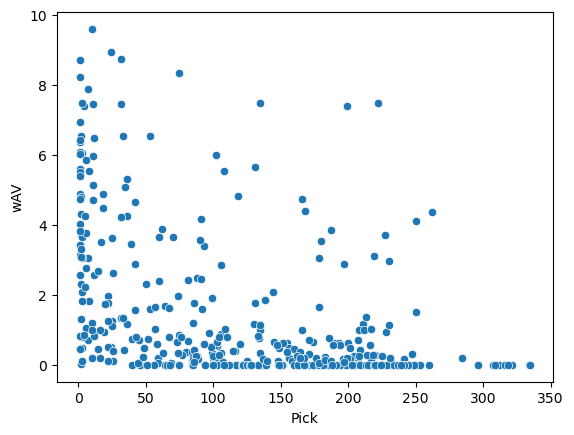

In [177]:
sns.scatterplot(df, x=df.Pick, y=df.wAV)